# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [3]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-09-19 14:47:58--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  52.4MB/s    in 4.1s    

2022-09-19 14:48:02 (42.0 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2022-09-19 14:48:02--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  55.5MB/s    in 1.1s    

2022-09-19 14:48:03 (55.5 MB/s) - ‘test_32x32.mat’ saved [64275384/

In [4]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [10]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [4]:
device

device(type='cuda', index=0)

# Загружаем данные

In [5]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [6]:
batch_size = 64

data_size = data_train.data.shape[0]

# Делим на train/val в соотношении 2 к 8
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Сэмплер нужен загрузки данных по одной картинке
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# лоадер служет для обработки за один раз batch_size сэмплов
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [7]:
# We'll use a special helper module to shape it into a flat tensor

# По сути слой, который сворачивает изображение в одномерный вектор
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [11]:
nn_model = nn.Sequential(
            nn.Conv2d(3, # Число входных каналов
                      64, # Число выходных каналов
                      3,  # Размер ядра(фильтра)
                      padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4), # Размер ядра(фильтра) = 4
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(), # В одномерный вектор
            nn.Linear(64*2*2, # in_features
                      10), # out_features
          )

nn_model.type(torch.cuda.FloatTensor) # Задаем 32х битный формат для данных
nn_model.to(device) # И отправляем вычисления на видеокарту

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor) # Аналогично делаем 32х битный лосс
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)



Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [12]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        # Переводим модель в режим тренировки
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0

        # Каждую эпоху перебираем наш трэйн лоадер

        # обрабатываем batch size за каждую итерацию
        for i_step, (x, y) in enumerate(train_loader):
            
            # Закидываем на GPU трэйн и тест данных из лоадера
            x_gpu = x.to(device)
            y_gpu = y.to(device)

            # Осуществляем прямой проход, создавая предсказание модели
            prediction = model(x_gpu)   

            # Считаем лосс 
            loss_value = loss(prediction, y_gpu)
            # Зануляем градиенты
            optimizer.zero_grad() # Почему мы зануляем градиенты перед обратным проходом? -> 
            # Потому что мы градиент рассчитваем при backward. А это градиенты с прошлого прохода

            # Осуществляем обратный проход, изменяя веса
            loss_value.backward()
            # Делаем шаг оптимизатора для изменений lr
            optimizer.step()
            
            # Считаем статистику
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    correct_samples = 0
    total_samples = 0

    for i_step, (x, y) in enumerate(train_loader):
      # Закидываем данные на GPU
      x_gpu = x.to(device)
      y_gpu = y.to(device)

      predict = model(x_gpu)


      _, indices = torch.max(predict, 1) # Считаем максимум по 1му измерению
      correct_samples += torch.sum(indices == y_gpu)
      total_samples += y.shape[0]


    return float(correct_samples) / total_samples
    #raise Exception("Not implemented")

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 1.458235, Train accuracy: 0.510238, Val accuracy: 0.756390
Average loss: 0.719324, Train accuracy: 0.781183, Val accuracy: 0.808467
Average loss: 0.609560, Train accuracy: 0.816486, Val accuracy: 0.803399
Average loss: 0.561789, Train accuracy: 0.832082, Val accuracy: 0.847507
Average loss: 0.528424, Train accuracy: 0.841364, Val accuracy: 0.852421


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [11]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1298: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. "


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

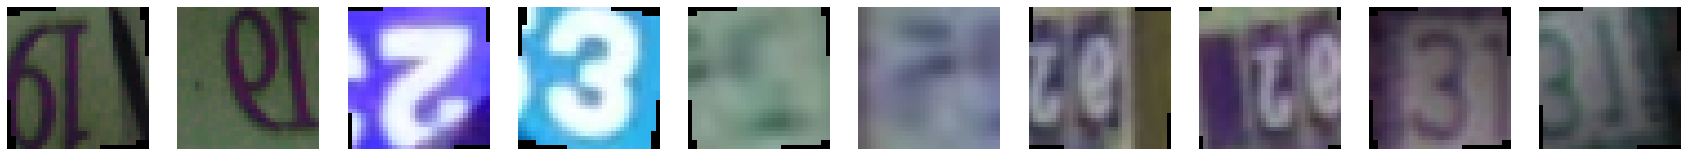

In [12]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [13]:
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

# TODO create new instances of loaders with the augmentations you chose
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1298: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. "


In [14]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.597687, Train accuracy: 0.818466, Val accuracy: 0.833788
Average loss: 0.558316, Train accuracy: 0.831536, Val accuracy: 0.847371
Average loss: 0.529928, Train accuracy: 0.839726, Val accuracy: 0.841381
Average loss: 0.512533, Train accuracy: 0.844009, Val accuracy: 0.851875
Average loss: 0.505810, Train accuracy: 0.847354, Val accuracy: 0.866311


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

Итак, LeNet5 состоял из:

1) Сверточного слоя c 6 фильтрами и размером выхода 28 на 28. Фильтр - 5 на 5 с шагом 1

2) Слоя, который кернелом 2 на 2 усредняет каждый из фильтров -> Заменим на MaxPool. Размер - 14 на 14

3) Сверточный слой с 16 фильтрами и размером 10 на 10

4) Аналогичный слою 2 уровень, итогового размера 5 на 5

5) Еще одна свертка - 120

6) После чего расположено 2 полносвязных слоя. 1й- 120, 2й- 84

При этом использовалась сигмоида, мы заменим её ReLu

In [32]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            nn.Conv2d(3, # Число входных каналов
                      6, # Число выходных каналов
                      5  # Размер ядра(фильтра)
                      ),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, # Размер ядра(фильтра) = 2
                         stride=2), # Шаг

            nn.Conv2d(6, 16, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, # Размер ядра(фильтра) = 2
                         stride=2), # Шаг 

            nn.Conv2d(16, 120, 5),
            nn.ReLU(inplace=True),

            Flattener(), # В одномерный вектор
            nn.Linear(120, # in_features
                      84), # out_features
            nn.ReLU(inplace=True),
            nn.Linear(84, # in_features
                      10), # out_features
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [17]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.232720, Train accuracy: 0.588165, Val accuracy: 0.837201
Average loss: 0.536103, Train accuracy: 0.840597, Val accuracy: 0.866106
Average loss: 0.450798, Train accuracy: 0.864843, Val accuracy: 0.894465
Average loss: 0.404456, Train accuracy: 0.879569, Val accuracy: 0.908644
Average loss: 0.370412, Train accuracy: 0.888578, Val accuracy: 0.917227
Average loss: 0.347097, Train accuracy: 0.896700, Val accuracy: 0.906870
Average loss: 0.330841, Train accuracy: 0.902058, Val accuracy: 0.911255
Average loss: 0.312648, Train accuracy: 0.906324, Val accuracy: 0.928250
Average loss: 0.299915, Train accuracy: 0.909497, Val accuracy: 0.933573
Average loss: 0.289264, Train accuracy: 0.913524, Val accuracy: 0.932413


# Успех!

# Подбор гиперпараметров

In [16]:
# В нашу тренировку добавим планировщик для LR

def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_sceduler_size):   
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_sceduler_size, gamma=0.5)
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        scheduler.step()
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)

            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history

In [20]:
import random

In [34]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 2, 5, 10]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 6

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!

params = [learning_rates, anneal_epochs, reg]
n_tryes = 10
n_epochs = 5

for i in range(n_tryes):

  # Каждый раз обновляем модель, иначе будем просто доучивать одну и ту же
  model = lenet_model

  # Выбираем случайное значение гиперпараметров
  random_value_par = [random.sample(param, 1)[0] for param in params]

  print(f"learning_rate: {random_value_par[0]}, anneal_epochs: {random_value_par[1]}, reg: {random_value_par[2]}")

  # Обучаем модель с выбранными гиперпараметрами
  loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
  # Uses Adam becouse it's better
  optimizer = optim.Adam(model.parameters(), 
                        lr= random_value_par[0], # lr
                        weight_decay= random_value_par[2]) # Регуляризация
  
  loss_history, train_history, val_history = train_model(model, 
                                                         train_aug_loader, 
                                                         val_loader, 
                                                         loss, 
                                                         optimizer, 
                                                         n_epochs,
                                                         step_sceduler_size= random_value_par[1]) # anneal_epochs
  print(f"loss_history: {loss_history}, train_history: {train_history}, val_history: {val_history}")

  # Запомним результат
  #run_record[Hyperparams(*params)] = random_value_par[0], random_value_par[1], random_value_par[2]
  run_record[Hyperparams(*random_value_par)] = RunResult(model, train_history, val_history, val_history[-1])

learning_rate: 0.001, anneal_epochs: 10, reg: 1e-05


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Average loss: 0.997896, Train accuracy: 0.679691, Val accuracy: 0.845374
Average loss: 0.527076, Train accuracy: 0.843617, Val accuracy: 0.876310
Average loss: 0.454180, Train accuracy: 0.864570, Val accuracy: 0.894226
Average loss: 0.412004, Train accuracy: 0.877214, Val accuracy: 0.897638
Average loss: 0.382606, Train accuracy: 0.884841, Val accuracy: 0.912313
loss_history: [0.9978957176208496, 0.5270755290985107, 0.45417988300323486, 0.41200393438339233, 0.3826059401035309], train_history: [0.6796914991639081, 0.8436166945363955, 0.864570180527591, 0.877213937139542, 0.8848411425451319], val_history: [0.8453741937685562, 0.8763095928744498, 0.8942258471828823, 0.8976384670511551, 0.9123127324847286]
learning_rate: 0.1, anneal_epochs: 2, reg: 1e-07
Average loss: 4.873050, Train accuracy: 0.184384, Val accuracy: 0.188257
Average loss: 2.244594, Train accuracy: 0.188257, Val accuracy: 0.188257
Average loss: 2.244669, Train accuracy: 0.187609, Val accuracy: 0.188257
Average loss: 2.2427

In [35]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.91, best hyperparams: Hyperparams(learning_rate=0.001, anneal_epochs=10, reg=1e-05)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

За основу возьмем архитектуру VGG16

In [17]:
vladimir_model = nn.Sequential(
            # input: 32x32x3
            # 1
            nn.Conv2d(3, # Число входных каналов
                      64, # Число выходных каналов
                      3,  # Размер ядра(фильтра)
                      padding= 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),

            nn.Conv2d(64, # Число входных каналов
                      64, # Число выходных каналов
                      3,  # Размер ядра(фильтра)
                      padding= 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),

            nn.MaxPool2d(2, # Размер ядра(фильтра) = 2
                         stride=2), # Шаг
            
            # 16x16x64
            # 2
            nn.Conv2d(64, # Число входных каналов
                      128, # Число выходных каналов
                      3,  # Размер ядра(фильтра)
                      padding= 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Dropout(0.1),

            nn.Conv2d(128, # Число входных каналов
                      128, # Число выходных каналов
                      3,  # Размер ядра(фильтра)
                      padding= 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Dropout(0.1),

            nn.MaxPool2d(2, stride=2), # Шаг

            # 8x8x128
            # 3
            nn.Conv2d(128, # Число входных каналов
                      256, # Число выходных каналов
                      3,  # Размер ядра(фильтра)
                      padding= 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Dropout(0.1),

            nn.Conv2d(256, # Число входных каналов
                      256, # Число выходных каналов
                      3,  # Размер ядра(фильтра)
                      padding= 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Dropout(0.1),

            nn.MaxPool2d(2, stride=2), # Шаг

            # 4x4x256
            # 4
            nn.Conv2d(256, # Число входных каналов
                      512, # Число выходных каналов
                      3,  # Размер ядра(фильтра)
                      padding= 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Dropout(0.1),

            nn.Conv2d(512, # Число входных каналов
                      512, # Число выходных каналов
                      3,  # Размер ядра(фильтра)
                      padding= 1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),

            nn.MaxPool2d(2, stride=2), # Шаг

            # 2x2x512
            # Final
            Flattener(),
            nn.Linear(2*2*512, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            nn.Dropout(0.2),

            nn.Linear(4096, 1000),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1000),
            nn.Dropout(0.1),

            nn.Linear(1000, 10)
          )

for module in vladimir_model.parameters():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))

    
vladimir_model.type(torch.cuda.FloatTensor)
vladimir_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(vladimir_model.parameters(), lr=1e-3, weight_decay=1e-6)

loss_history, train_history, val_history = train_model(vladimir_model, train_aug_loader, val_loader, loss, optimizer, 10, 5)

Average loss: 1.089454, Train accuracy: 0.629628, Val accuracy: 0.881650
Average loss: 0.364506, Train accuracy: 0.888390, Val accuracy: 0.919343
Average loss: 0.296146, Train accuracy: 0.912620, Val accuracy: 0.943095
Average loss: 0.261283, Train accuracy: 0.923899, Val accuracy: 0.946814
Average loss: 0.183377, Train accuracy: 0.947309, Val accuracy: 0.971146
Average loss: 0.163421, Train accuracy: 0.952803, Val accuracy: 0.972904
Average loss: 0.149072, Train accuracy: 0.956796, Val accuracy: 0.967904
Average loss: 0.134754, Train accuracy: 0.961011, Val accuracy: 0.976316
Average loss: 0.119503, Train accuracy: 0.964987, Val accuracy: 0.981333
Average loss: 0.070842, Train accuracy: 0.979729, Val accuracy: 0.991520


# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [18]:
# TODO Write the code to compute accuracy on test set
final_test_accuracy = 0.0

test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(vladimir_model, test_loader)

print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9915196396273419


Ооооо ееее